https://towardsdatascience.com/how-to-train-an-image-classifier-in-pytorch-and-use-it-to-perform-basic-inference-on-single-images-99465a1e9bf5

In [1]:
model_name = "squeezenet1_1"

# Train

## Import the modules

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

import time

## Moving Your Custom Datasets Into Your Cloud VM

In [3]:
%cd ..
from google.colab import drive
drive.mount('/content/gdrive')

/
Mounted at /content/gdrive


In [4]:
!ls /content/gdrive/MyDrive/Classification/City/v5

data  squeezenet1_1  squeezenet1_1.ipynb


In [5]:
%cd content

/content


In [6]:
!pwd

/content


In [7]:
!mkdir data

In [8]:
!cp /content/gdrive/MyDrive/Classification/City/v5/data/train.zip ./
!cp /content/gdrive/MyDrive/Classification/City/v5/data/valid.zip ./

In [9]:
!unzip ./train.zip -d data/
!unzip ./valid.zip -d data/

Archive:  ./train.zip
   creating: data/train/
   creating: data/train/Birmingham/
  inflating: data/train/Birmingham/00076.jpg  
  inflating: data/train/Birmingham/00077.jpg  
  inflating: data/train/Birmingham/00078.jpg  
  inflating: data/train/Birmingham/00079.jpg  
  inflating: data/train/Birmingham/00080.jpg  
  inflating: data/train/Birmingham/00081.jpg  
  inflating: data/train/Birmingham/00082.jpg  
  inflating: data/train/Birmingham/00083.jpg  
  inflating: data/train/Birmingham/00084.jpg  
  inflating: data/train/Birmingham/00085.jpg  
  inflating: data/train/Birmingham/00086.jpg  
  inflating: data/train/Birmingham/00087.jpg  
  inflating: data/train/Birmingham/00088.jpg  
  inflating: data/train/Birmingham/00089.jpg  
  inflating: data/train/Birmingham/00090.jpg  
  inflating: data/train/Birmingham/00091.jpg  
  inflating: data/train/Birmingham/00092.jpg  
  inflating: data/train/Birmingham/00093.jpg  
  inflating: data/train/Birmingham/00094.jpg  
  inflating: data/train/

## Define the train / validation dataset loader

In [10]:
data_dir_train = 'data/train'
data_dir_valid = 'data/valid'

def load_split_train_test(datadirtrain, datadirtest):
    
    train_transforms = transforms.Compose([transforms.Resize(224),
                                       transforms.ToTensor(),
                                       transforms.Normalize(
                                           mean=[0.485, 0.456, 0.406],
                                           std=[0.229, 0.224, 0.225],)
                                       ])    
    
    test_transforms = transforms.Compose([transforms.Resize(224),
                                       transforms.ToTensor(),
                                       transforms.Normalize(
                                           mean=[0.485, 0.456, 0.406],
                                           std=[0.229, 0.224, 0.225],)
                                       ])    
    
    train_data = datasets.ImageFolder(datadirtrain,       
                    transform=train_transforms)
    test_data = datasets.ImageFolder(datadirtest,
                    transform=test_transforms)    
    
    trainloader = torch.utils.data.DataLoader(train_data, batch_size=64)
    testloader = torch.utils.data.DataLoader(test_data, batch_size=64)
    
    return trainloader, testloader

trainloader, testloader = load_split_train_test(data_dir_train, data_dir_valid)
print(trainloader.dataset.classes)

['Birmingham', 'Chester', 'Dublin', 'Edinburgh', 'Exeter', 'Glasgow', 'London', 'Newcastle', 'Sheffield']


## Determine whether we have GPU

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [12]:
torch.cuda.is_available()

True

## Load a pretrained model

In [13]:
model = models.squeezenet1_1(pretrained=True)
print(model)

Downloading: "https://download.pytorch.org/models/squeezenet1_1-b8a52dc0.pth" to /root/.cache/torch/hub/checkpoints/squeezenet1_1-b8a52dc0.pth


  0%|          | 0.00/4.73M [00:00<?, ?B/s]

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): MaxPool2d


- Freeze the pre-trained layers, so we don't backprop through them during training
- Re-define the final fully-connected layer that we'll train with our images
- Create the loss function https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss
- Pick an optimizer
- Pick the learning rate


In [14]:
for param in model.parameters():
    param.requires_grad = False

num_classes = len(trainloader.dataset.classes)
print(num_classes)

model.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))

optimizer = optim.Adam(model.classifier[1].parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

model.to(device)

9


SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): MaxPool2d

## Train the model

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


Epoch 1/500.. Train loss: 2.815.. Test loss: 2.483.. Test accuracy: 0.112
Epoch 1/500.. Time: 6.280
Epoch 2/500.. Train loss: 2.727.. Test loss: 2.199.. Test accuracy: 0.128
Epoch 2/500.. Train loss: 2.195.. Test loss: 2.179.. Test accuracy: 0.146
Epoch 2/500.. Time: 7.386
Epoch 3/500.. Train loss: 2.184.. Test loss: 2.162.. Test accuracy: 0.175
Epoch 3/500.. Train loss: 2.223.. Test loss: 2.149.. Test accuracy: 0.232
Epoch 3/500.. Time: 7.145
Epoch 4/500.. Train loss: 2.110.. Test loss: 2.140.. Test accuracy: 0.255
Epoch 4/500.. Time: 5.900
Epoch 5/500.. Train loss: 2.182.. Test loss: 2.103.. Test accuracy: 0.312
Epoch 5/500.. Train loss: 2.076.. Test loss: 2.092.. Test accuracy: 0.363
Epoch 5/500.. Time: 7.140
Epoch 6/500.. Train loss: 2.060.. Test loss: 2.032.. Test accuracy: 0.366
Epoch 6/500.. Train loss: 2.040.. Test loss: 1.977.. Test accuracy: 0.413
Epoch 6/500.. Time: 7.001
Epoch 7/500.. Train loss: 2.017.. Test loss: 1.923.. Test accuracy: 0.417
Epoch 7/500.. Time: 5.475
Epoc

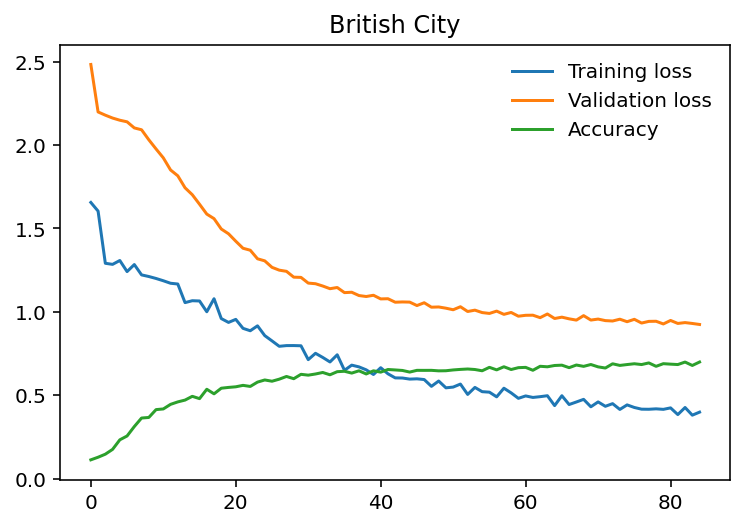

Epoch 51/500.. Train loss: 0.678.. Test loss: 0.943.. Test accuracy: 0.683
Epoch 51/500.. Time: 5.552
Epoch 52/500.. Train loss: 0.608.. Test loss: 0.922.. Test accuracy: 0.689
Epoch 52/500.. Train loss: 0.680.. Test loss: 0.936.. Test accuracy: 0.701
Epoch 52/500.. Time: 7.026
Epoch 53/500.. Train loss: 0.629.. Test loss: 0.923.. Test accuracy: 0.684
Epoch 53/500.. Train loss: 0.641.. Test loss: 0.923.. Test accuracy: 0.704
Epoch 53/500.. Time: 6.995
Epoch 54/500.. Train loss: 0.600.. Test loss: 0.938.. Test accuracy: 0.686
Epoch 54/500.. Time: 5.547
Epoch 55/500.. Train loss: 0.653.. Test loss: 0.919.. Test accuracy: 0.689
Epoch 55/500.. Train loss: 0.620.. Test loss: 0.940.. Test accuracy: 0.694
Epoch 55/500.. Time: 6.925
Epoch 56/500.. Train loss: 0.590.. Test loss: 0.920.. Test accuracy: 0.697
Epoch 56/500.. Train loss: 0.622.. Test loss: 0.922.. Test accuracy: 0.706
Epoch 56/500.. Time: 7.004
Epoch 57/500.. Train loss: 0.616.. Test loss: 0.928.. Test accuracy: 0.699
Epoch 57/500.

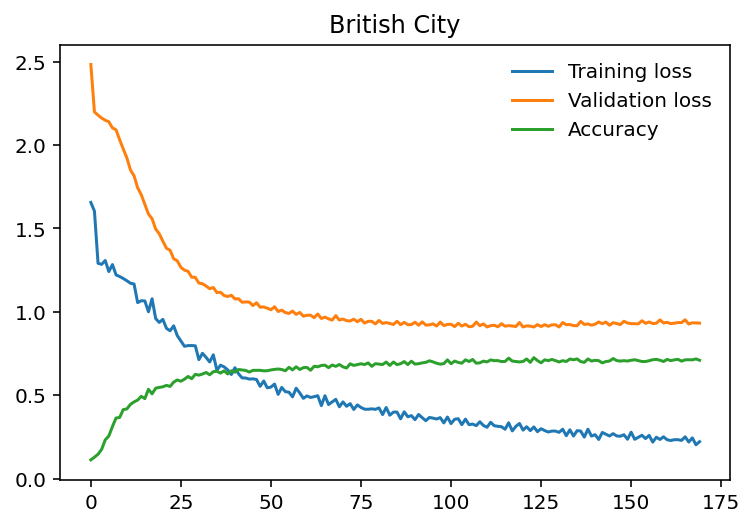

Epoch 101/500.. Train loss: 0.392.. Test loss: 0.953.. Test accuracy: 0.715
Epoch 101/500.. Time: 5.575
Epoch 102/500.. Train loss: 0.353.. Test loss: 0.952.. Test accuracy: 0.691
Epoch 102/500.. Train loss: 0.398.. Test loss: 0.946.. Test accuracy: 0.714
Epoch 102/500.. Time: 7.028
Epoch 103/500.. Train loss: 0.347.. Test loss: 0.935.. Test accuracy: 0.707
Epoch 103/500.. Train loss: 0.365.. Test loss: 0.943.. Test accuracy: 0.717
Epoch 103/500.. Time: 6.959
Epoch 104/500.. Train loss: 0.343.. Test loss: 0.947.. Test accuracy: 0.720
Epoch 104/500.. Time: 5.546
Epoch 105/500.. Train loss: 0.364.. Test loss: 0.937.. Test accuracy: 0.707
Epoch 105/500.. Train loss: 0.382.. Test loss: 0.953.. Test accuracy: 0.714
Epoch 105/500.. Time: 7.019
Epoch 106/500.. Train loss: 0.361.. Test loss: 0.949.. Test accuracy: 0.712
Epoch 106/500.. Train loss: 0.365.. Test loss: 0.940.. Test accuracy: 0.714
Epoch 106/500.. Time: 6.968
Epoch 107/500.. Train loss: 0.339.. Test loss: 0.941.. Test accuracy: 0.

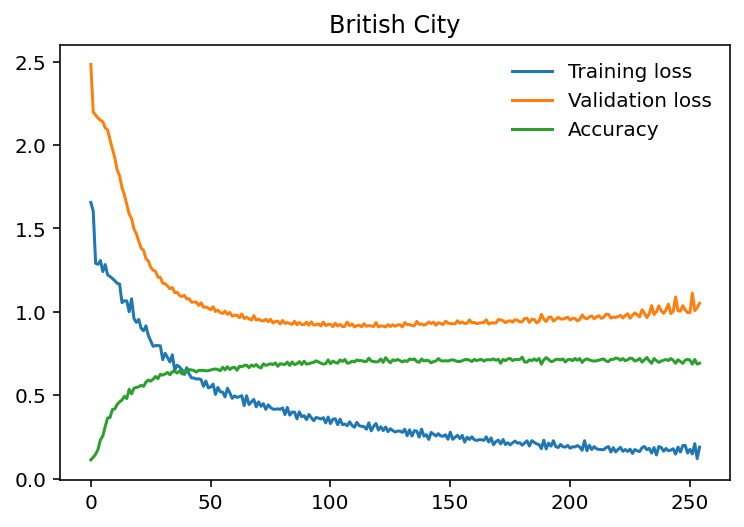

Epoch 151/500.. Train loss: 0.343.. Test loss: 1.011.. Test accuracy: 0.710
Epoch 151/500.. Time: 5.495
Epoch 152/500.. Train loss: 0.272.. Test loss: 0.986.. Test accuracy: 0.720
Epoch 152/500.. Train loss: 0.282.. Test loss: 1.000.. Test accuracy: 0.712
Epoch 152/500.. Time: 6.936
Epoch 153/500.. Train loss: 0.266.. Test loss: 1.038.. Test accuracy: 0.704
Epoch 153/500.. Train loss: 0.257.. Test loss: 0.992.. Test accuracy: 0.717
Epoch 153/500.. Time: 6.950
Epoch 154/500.. Train loss: 0.251.. Test loss: 1.002.. Test accuracy: 0.720
Epoch 154/500.. Time: 5.496
Epoch 155/500.. Train loss: 0.260.. Test loss: 1.035.. Test accuracy: 0.691
Epoch 155/500.. Train loss: 0.274.. Test loss: 1.010.. Test accuracy: 0.707
Epoch 155/500.. Time: 6.975
Epoch 156/500.. Train loss: 0.218.. Test loss: 0.991.. Test accuracy: 0.728
Epoch 156/500.. Train loss: 0.249.. Test loss: 1.004.. Test accuracy: 0.712
Epoch 156/500.. Time: 6.919
Epoch 157/500.. Train loss: 0.242.. Test loss: 1.008.. Test accuracy: 0.

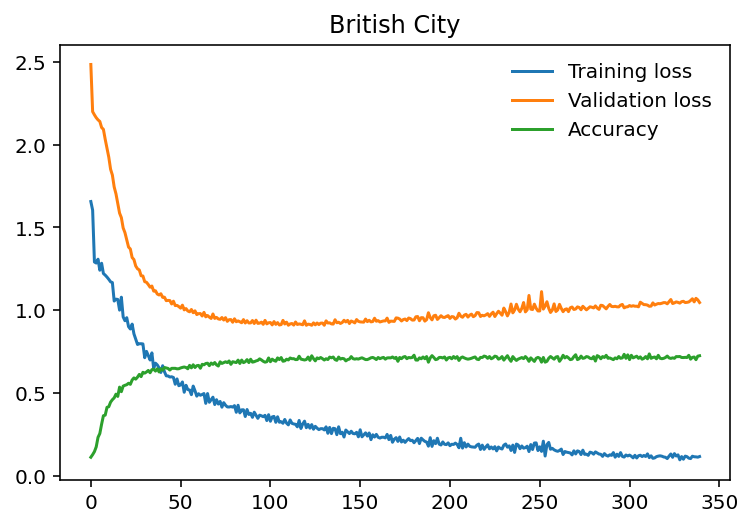

Epoch 201/500.. Train loss: 0.203.. Test loss: 1.052.. Test accuracy: 0.728
Epoch 201/500.. Time: 5.509
Epoch 202/500.. Train loss: 0.169.. Test loss: 1.095.. Test accuracy: 0.697
Epoch 202/500.. Train loss: 0.219.. Test loss: 1.055.. Test accuracy: 0.727
Epoch 202/500.. Time: 7.041
Epoch 203/500.. Train loss: 0.161.. Test loss: 1.049.. Test accuracy: 0.728
Epoch 203/500.. Train loss: 0.193.. Test loss: 1.107.. Test accuracy: 0.704
Epoch 203/500.. Time: 6.940
Epoch 204/500.. Train loss: 0.197.. Test loss: 1.055.. Test accuracy: 0.713
Epoch 204/500.. Time: 5.529
Epoch 205/500.. Train loss: 0.196.. Test loss: 1.034.. Test accuracy: 0.728
Epoch 205/500.. Train loss: 0.195.. Test loss: 1.075.. Test accuracy: 0.720
Epoch 205/500.. Time: 6.979
Epoch 206/500.. Train loss: 0.183.. Test loss: 1.153.. Test accuracy: 0.702
Epoch 206/500.. Train loss: 0.235.. Test loss: 1.055.. Test accuracy: 0.714
Epoch 206/500.. Time: 6.921
Epoch 207/500.. Train loss: 0.187.. Test loss: 1.051.. Test accuracy: 0.

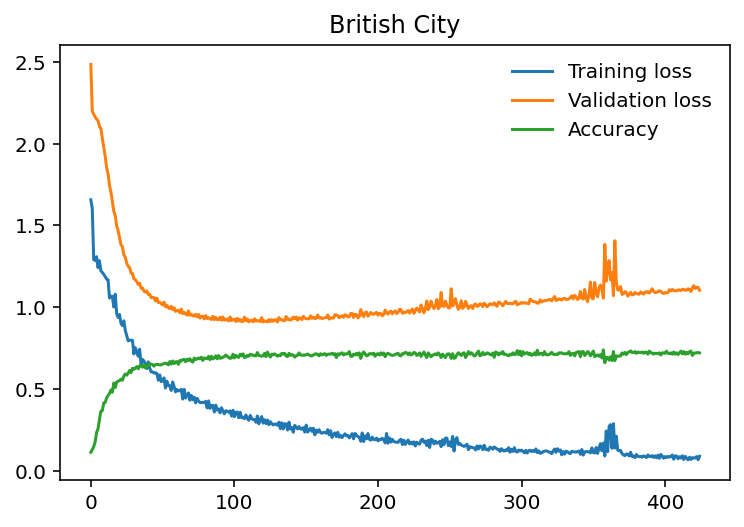

Epoch 251/500.. Train loss: 0.138.. Test loss: 1.110.. Test accuracy: 0.725
Epoch 251/500.. Time: 5.551
Epoch 252/500.. Train loss: 0.138.. Test loss: 1.107.. Test accuracy: 0.720
Epoch 252/500.. Train loss: 0.144.. Test loss: 1.112.. Test accuracy: 0.725
Epoch 252/500.. Time: 6.950
Epoch 253/500.. Train loss: 0.130.. Test loss: 1.114.. Test accuracy: 0.728
Epoch 253/500.. Train loss: 0.147.. Test loss: 1.117.. Test accuracy: 0.717
Epoch 253/500.. Time: 7.068
Epoch 254/500.. Train loss: 0.111.. Test loss: 1.107.. Test accuracy: 0.723
Epoch 254/500.. Time: 5.511
Epoch 255/500.. Train loss: 0.156.. Test loss: 1.121.. Test accuracy: 0.712
Epoch 255/500.. Train loss: 0.144.. Test loss: 1.124.. Test accuracy: 0.725
Epoch 255/500.. Time: 7.001
Epoch 256/500.. Train loss: 0.119.. Test loss: 1.122.. Test accuracy: 0.717
Epoch 256/500.. Train loss: 0.142.. Test loss: 1.122.. Test accuracy: 0.719
Epoch 256/500.. Time: 6.987
Epoch 257/500.. Train loss: 0.123.. Test loss: 1.106.. Test accuracy: 0.

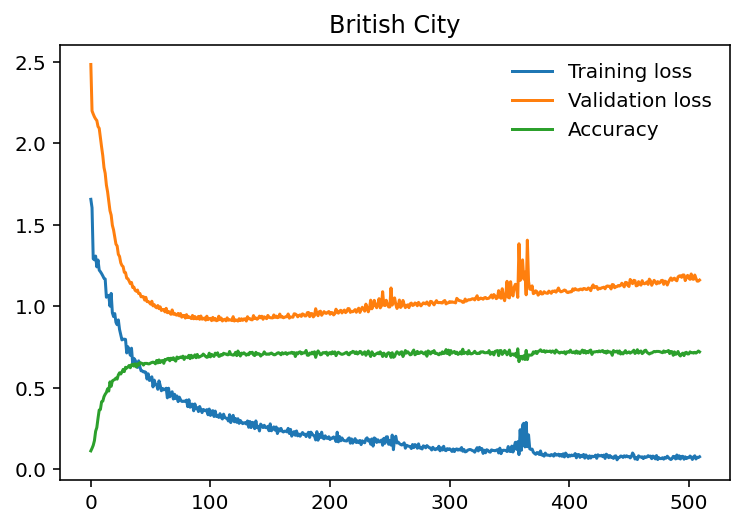

Epoch 301/500.. Train loss: 0.094.. Test loss: 1.154.. Test accuracy: 0.723
Epoch 301/500.. Time: 5.570
Epoch 302/500.. Train loss: 0.098.. Test loss: 1.158.. Test accuracy: 0.709
Epoch 302/500.. Train loss: 0.111.. Test loss: 1.170.. Test accuracy: 0.725
Epoch 302/500.. Time: 7.076
Epoch 303/500.. Train loss: 0.091.. Test loss: 1.173.. Test accuracy: 0.717
Epoch 303/500.. Train loss: 0.104.. Test loss: 1.157.. Test accuracy: 0.712
Epoch 303/500.. Time: 6.972
Epoch 304/500.. Train loss: 0.097.. Test loss: 1.162.. Test accuracy: 0.728
Epoch 304/500.. Time: 5.633
Epoch 305/500.. Train loss: 0.129.. Test loss: 1.166.. Test accuracy: 0.720
Epoch 305/500.. Train loss: 0.096.. Test loss: 1.163.. Test accuracy: 0.722
Epoch 305/500.. Time: 7.009
Epoch 306/500.. Train loss: 0.099.. Test loss: 1.167.. Test accuracy: 0.715
Epoch 306/500.. Train loss: 0.114.. Test loss: 1.160.. Test accuracy: 0.725
Epoch 306/500.. Time: 7.029
Epoch 307/500.. Train loss: 0.110.. Test loss: 1.163.. Test accuracy: 0.

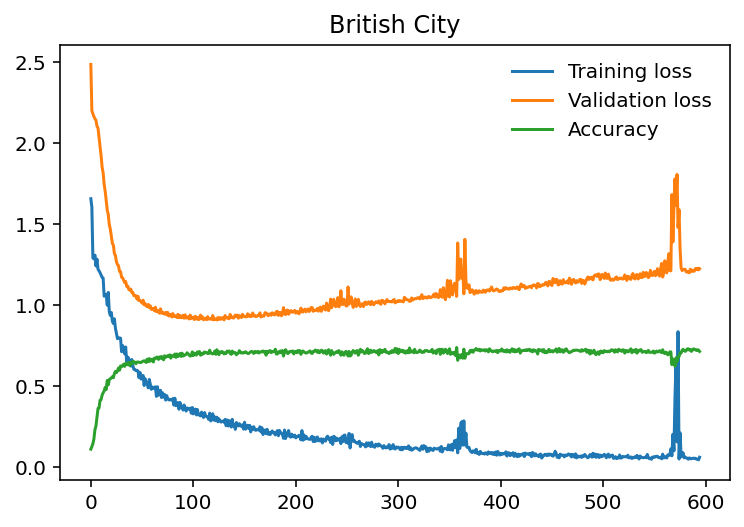

Epoch 351/500.. Train loss: 0.088.. Test loss: 1.220.. Test accuracy: 0.720
Epoch 351/500.. Time: 5.606
Epoch 352/500.. Train loss: 0.086.. Test loss: 1.207.. Test accuracy: 0.723
Epoch 352/500.. Train loss: 0.089.. Test loss: 1.205.. Test accuracy: 0.725
Epoch 352/500.. Time: 7.046
Epoch 353/500.. Train loss: 0.087.. Test loss: 1.216.. Test accuracy: 0.717
Epoch 353/500.. Train loss: 0.098.. Test loss: 1.229.. Test accuracy: 0.722
Epoch 353/500.. Time: 6.996
Epoch 354/500.. Train loss: 0.077.. Test loss: 1.210.. Test accuracy: 0.723
Epoch 354/500.. Time: 5.556
Epoch 355/500.. Train loss: 0.107.. Test loss: 1.220.. Test accuracy: 0.722
Epoch 355/500.. Train loss: 0.100.. Test loss: 1.235.. Test accuracy: 0.725
Epoch 355/500.. Time: 6.977
Epoch 356/500.. Train loss: 0.084.. Test loss: 1.219.. Test accuracy: 0.725
Epoch 356/500.. Train loss: 0.077.. Test loss: 1.240.. Test accuracy: 0.730
Epoch 356/500.. Time: 7.006
Epoch 357/500.. Train loss: 0.090.. Test loss: 1.228.. Test accuracy: 0.

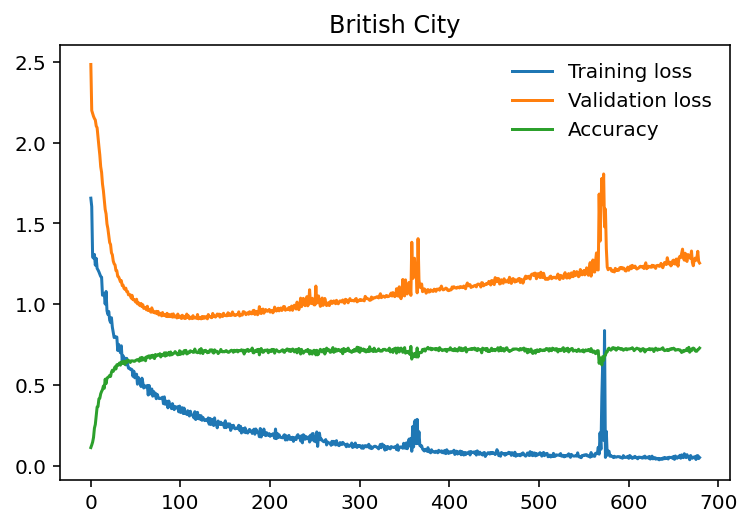

Epoch 401/500.. Train loss: 0.101.. Test loss: 1.291.. Test accuracy: 0.725
Epoch 401/500.. Time: 5.556
Epoch 402/500.. Train loss: 0.083.. Test loss: 1.291.. Test accuracy: 0.707
Epoch 402/500.. Train loss: 0.062.. Test loss: 1.273.. Test accuracy: 0.712
Epoch 402/500.. Time: 7.027
Epoch 403/500.. Train loss: 0.075.. Test loss: 1.270.. Test accuracy: 0.725
Epoch 403/500.. Train loss: 0.098.. Test loss: 1.300.. Test accuracy: 0.722
Epoch 403/500.. Time: 7.020
Epoch 404/500.. Train loss: 0.054.. Test loss: 1.271.. Test accuracy: 0.725
Epoch 404/500.. Time: 5.600
Epoch 405/500.. Train loss: 0.074.. Test loss: 1.272.. Test accuracy: 0.728
Epoch 405/500.. Train loss: 0.068.. Test loss: 1.288.. Test accuracy: 0.714
Epoch 405/500.. Time: 7.021
Epoch 406/500.. Train loss: 0.071.. Test loss: 1.255.. Test accuracy: 0.728
Epoch 406/500.. Train loss: 0.084.. Test loss: 1.274.. Test accuracy: 0.717
Epoch 406/500.. Time: 7.024
Epoch 407/500.. Train loss: 0.075.. Test loss: 1.293.. Test accuracy: 0.

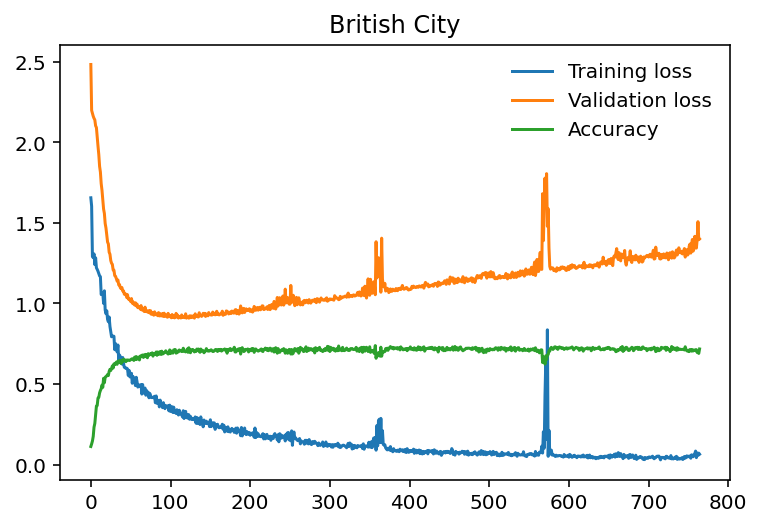

Epoch 451/500.. Train loss: 0.166.. Test loss: 1.615.. Test accuracy: 0.683
Epoch 451/500.. Time: 5.983
Epoch 452/500.. Train loss: 0.200.. Test loss: 1.343.. Test accuracy: 0.715
Epoch 452/500.. Train loss: 0.121.. Test loss: 1.384.. Test accuracy: 0.718
Epoch 452/500.. Time: 7.531
Epoch 453/500.. Train loss: 0.122.. Test loss: 1.428.. Test accuracy: 0.705
Epoch 453/500.. Train loss: 0.155.. Test loss: 1.504.. Test accuracy: 0.697
Epoch 453/500.. Time: 7.441
Epoch 454/500.. Train loss: 0.099.. Test loss: 1.518.. Test accuracy: 0.677
Epoch 454/500.. Time: 5.904
Epoch 455/500.. Train loss: 0.282.. Test loss: 1.468.. Test accuracy: 0.685
Epoch 455/500.. Train loss: 0.124.. Test loss: 1.790.. Test accuracy: 0.653
Epoch 455/500.. Time: 7.473
Epoch 456/500.. Train loss: 0.233.. Test loss: 1.420.. Test accuracy: 0.693
Epoch 456/500.. Train loss: 0.162.. Test loss: 1.484.. Test accuracy: 0.710
Epoch 456/500.. Time: 7.437
Epoch 457/500.. Train loss: 0.332.. Test loss: 1.711.. Test accuracy: 0.

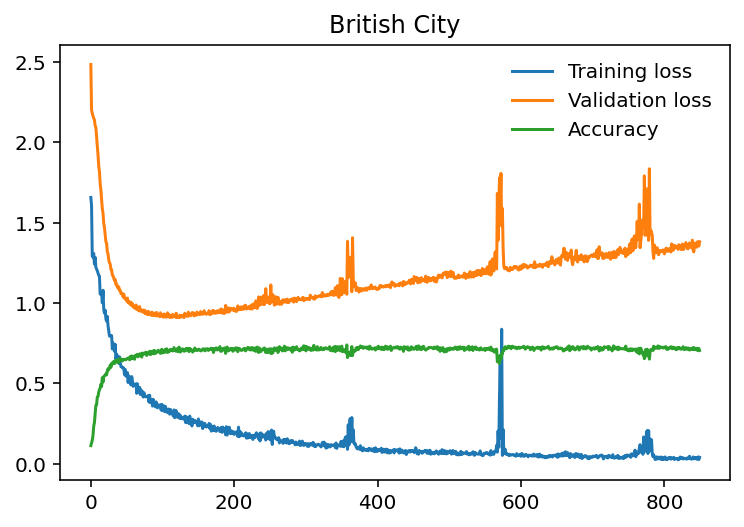

In [15]:
epochs = 500
steps = 0
running_loss = 0
print_every = 10
train_losses, test_losses, accuracy_lst = [], [], []

for epoch in range(epochs):
    start = time.time()
    
    for inputs, labels in trainloader:
        steps += 1
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        if steps % print_every == 0:
            
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in testloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    test_loss += batch_loss.item()
                    
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                    
            train_losses.append(running_loss/len(trainloader))
            test_losses.append(test_loss/len(testloader)) 
            accuracy_lst.append(accuracy/len(testloader))                   
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(testloader):.3f}.. "
                  f"Test accuracy: {accuracy/len(testloader):.3f}")
            running_loss = 0
            model.train()
            
    end = time.time()
    print(f"Epoch {epoch+1}/{epochs}.. "
          f"Time: {end-start:.3f}")
    
    if (epoch+1) % 50 == 0:
      torch.save(model, f'city_{model_name}_{epoch+1}.pth')
      !cp 'city_{model_name}_{epoch+1}.pth' /content/gdrive/MyDrive/Classification/City/v5/squeezenet1_1/

      plt.plot(train_losses, label='Training loss')
      plt.plot(test_losses, label='Validation loss')
      plt.plot(accuracy_lst, label='Accuracy')
      plt.title('British City')
      plt.legend(frameon=False)
      plt.show()



## Plot loss

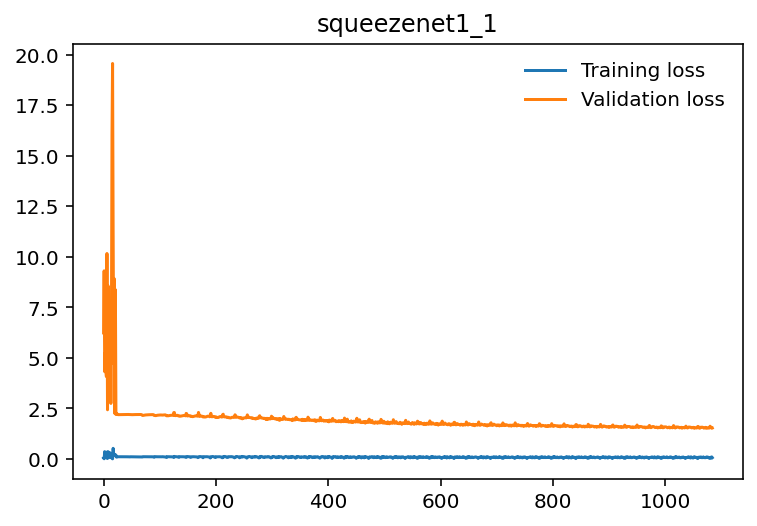

In [ ]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.title(model_name)
plt.legend(frameon=False)
plt.show()

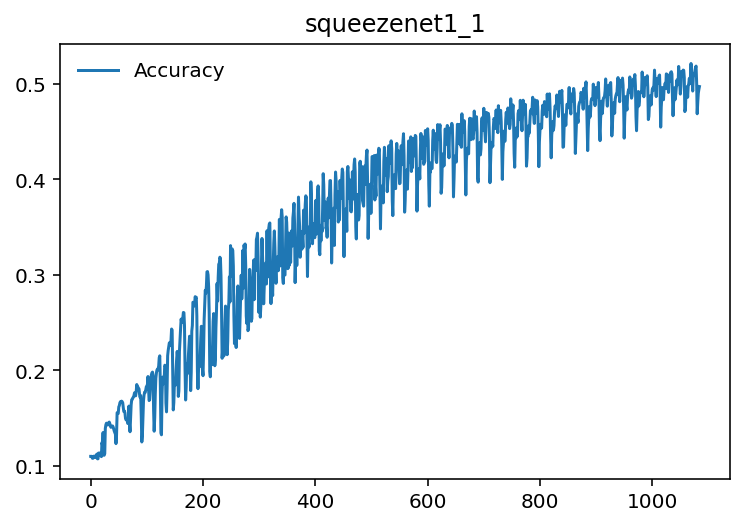

In [ ]:
plt.plot(accuracy_lst, label='Accuracy')
plt.title(model_name)
plt.legend(frameon=False)
plt.show()

# Train from last stop

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from PIL import Image
from torch.autograd import Variable

%cd ..
from google.colab import drive
drive.mount('/content/gdrive')

%cd content

!mkdir data
!cp /content/gdrive/MyDrive/Classification/City/v4/data/train.zip ./
!cp /content/gdrive/MyDrive/Classification/City/v4/data/valid.zip ./
!unzip ./train.zip -d data/
!unzip ./valid.zip -d data/

data_dir_train = 'data/train'
data_dir_valid = 'data/valid'

def load_split_train_test(datadirtrain, datadirtest):
    
    train_transforms = transforms.Compose([transforms.Resize(224),
                                       transforms.ToTensor(),
                                       transforms.Normalize(
                                           mean=[0.485, 0.456, 0.406],
                                           std=[0.229, 0.224, 0.225],)
                                       ])    
    
    test_transforms = transforms.Compose([transforms.Resize(224),
                                       transforms.ToTensor(),
                                       transforms.Normalize(
                                           mean=[0.485, 0.456, 0.406],
                                           std=[0.229, 0.224, 0.225],)
                                       ])    
    
    train_data = datasets.ImageFolder(datadirtrain,       
                    transform=train_transforms)
    test_data = datasets.ImageFolder(datadirtest,
                    transform=test_transforms)    
    
    trainloader = torch.utils.data.DataLoader(train_data, batch_size=64)
    testloader = torch.utils.data.DataLoader(test_data, batch_size=64)
    
    return trainloader, testloader

trainloader, testloader = load_split_train_test(data_dir_train, data_dir_valid)
print(trainloader.dataset.classes)

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: data/train/Newcastle/SafeRotate_015_Newcastle.jpg  
  inflating: data/train/Newcastle/SafeRotate_016_Newcastle.jpg  
  inflating: data/train/Newcastle/SafeRotate_017_Newcastle.jpg  
  inflating: data/train/Newcastle/SafeRotate_018_Newcastle.jpg  
  inflating: data/train/Newcastle/SafeRotate_020_Newcastle.jpg  
  inflating: data/train/Newcastle/SafeRotate_023_Newcastle.jpg  
  inflating: data/train/Newcastle/SafeRotate_026_Newcastle.jpg  
  inflating: data/train/Newcastle/SafeRotate_027_Newcastle.jpg  
  inflating: data/train/Newcastle/SafeRotate_028_Newcastle.jpg  
  inflating: data/train/Newcastle/SafeRotate_029_Newcastle.jpg  
  inflating: data/train/Newcastle/SafeRotate_030_Newcastle.jpg  
  inflating: data/train/Newcastle/SafeRotate_033_Newcastle.jpg  
  inflating: data/train/Newcastle/SafeRotate_034_Newcastle.jpg  
  inflating: data/train/Newcastle/SafeRotate_035_Newcastle.jpg  
  inflating: data/trai

In [ ]:
!cp /content/gdrive/MyDrive/Classification/City/v4/squeezenet1_1/city_squeezenet1_1_100.pth ./
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model=torch.load(f'city_{model_name}_100.pth')
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier[1].parameters(), lr=0.001)
model

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): MaxPool2d

In [ ]:
import time
# from torchvision.models.squeezenet import squeezenet1_1
epochs = 50
steps = 0
running_loss = 0
print_every = 10
train_losses, test_losses, accuracy_lst = [], [], []

for epoch in range(epochs):
    start = time.time()
    
    for inputs, labels in trainloader:
        steps += 1
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        if steps % print_every == 0:
            
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in testloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    test_loss += batch_loss.item()
                    
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                    
            train_losses.append(running_loss/len(trainloader))
            test_losses.append(test_loss/len(testloader)) 
            accuracy_lst.append(accuracy/len(testloader))                   
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(testloader):.3f}.. "
                  f"Test accuracy: {accuracy/len(testloader):.3f}")
            running_loss = 0
            model.train()
            
    end = time.time()
    print(f"Epoch {epoch+1}/{epochs}.. "
          f"Time: {end-start:.3f}")
    
    if (epoch+1) % 50 == 0:
      torch.save(model, f'city_{model_name}_{epoch+101}.pth')
      !cp 'city_{model_name}_{epoch+101}.pth' /content/gdrive/MyDrive/Classification/City/v4/squeezenet1_1/

Epoch 1/50.. Train loss: 1.708.. Test loss: 1.431.. Test accuracy: 0.555
Epoch 1/50.. Train loss: 1.134.. Test loss: 1.475.. Test accuracy: 0.550
Epoch 1/50.. Train loss: 1.155.. Test loss: 1.505.. Test accuracy: 0.550
Epoch 1/50.. Train loss: 1.202.. Test loss: 1.531.. Test accuracy: 0.550
Epoch 1/50.. Train loss: 1.542.. Test loss: 1.561.. Test accuracy: 0.548
Epoch 1/50.. Train loss: 1.875.. Test loss: 1.602.. Test accuracy: 0.534
Epoch 1/50.. Train loss: 1.315.. Test loss: 1.635.. Test accuracy: 0.524
Epoch 1/50.. Train loss: 1.501.. Test loss: 1.640.. Test accuracy: 0.518
Epoch 1/50.. Train loss: 1.296.. Test loss: 1.642.. Test accuracy: 0.512
Epoch 1/50.. Train loss: 1.595.. Test loss: 1.643.. Test accuracy: 0.505
Epoch 1/50.. Train loss: 1.783.. Test loss: 1.638.. Test accuracy: 0.515
Epoch 1/50.. Train loss: 1.776.. Test loss: 1.631.. Test accuracy: 0.517
Epoch 1/50.. Train loss: 1.844.. Test loss: 1.629.. Test accuracy: 0.523
Epoch 1/50.. Train loss: 1.687.. Test loss: 1.623..

In [ ]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.title(model_name)
plt.legend(frameon=False)
plt.show()

In [ ]:
plt.plot(accuracy_lst, label='Accuracy')
plt.title(model_name)
plt.legend(frameon=False)
plt.show()

# Test

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from PIL import Image
from torch.autograd import Variable

In [ ]:
data_dir = '/content/gdrive/MyDrive/Classification/Letter/v2/data/test'

test_transforms = transforms.Compose([transforms.Resize(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                          [0.229, 0.224, 0.225])
                                     ])

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model=torch.load(f'letters_{model_name}.pth')
model.eval()
model

In [ ]:


def predict_image(image):
    image_tensor = test_transforms(image).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input = Variable(image_tensor)
    input = input.to(device)
    output = model(input)
    index = output.data.cpu().numpy().argmax()
    return index  

def get_random_images(num):
    data = datasets.ImageFolder(data_dir, transform=test_transforms)
    classes = data.classes
    indices = list(range(len(data)))
    np.random.shuffle(indices)
    idx = indices[:num]
    from torch.utils.data.sampler import SubsetRandomSampler
    sampler = SubsetRandomSampler(idx)
    loader = torch.utils.data.DataLoader(data, sampler=sampler, batch_size=num)
    dataiter = iter(loader)
    images, labels = dataiter.next()
    return images, labels



In [ ]:
to_pil = transforms.ToPILImage()
images, labels = get_random_images(5)
fig=plt.figure(figsize=(10,10))
for ii in range(len(images)):
    image = to_pil(images[ii])
    index = predict_image(image)
    sub = fig.add_subplot(1, len(images), ii+1)
    res = int(labels[ii]) == index
    sub.set_title(str(classes[index]) + ":" + str(res))
    plt.axis('off')
    plt.imshow(image)
plt.show()